### 数据集准备

In [1]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from math import log
import operator # operator是Python内置的操作模块，提供了一系列函数来执行基本的运算符操作
import pickle # pickle模块实现了基本的数据序列和反序列化功能

def createDataSet():
    """
    创建数据集和标签
    F1-AGE: 年龄 (0: 青年, 1: 中年, 2: 老年)
    F2-WORK: 是否有工作 (0: 否, 1: 是)
    F3-HOME: 是否有房产 (0: 否, 1: 是)
    F4-LOAN: 信贷情况 (0: 一般, 1: 好, 2: 非常好)
    """
    dataSet = [
        [0, 0, 0, 0, 'no'],
        [0, 0, 0, 1, 'no'],
        [0, 1, 0, 1, 'yes'],
        [0, 1, 1, 0, 'yes'],
        [0, 0, 0, 0, 'no'],
        [1, 0, 0, 0, 'no'],
        [1, 0, 0, 1, 'no'],
        [1, 1, 1, 1, 'yes'],
        [1, 0, 1, 2, 'yes'],
        [1, 0, 1, 2, 'yes'],
        [2, 0, 1, 2, 'yes'],
        [2, 0, 1, 1, 'yes'],
        [2, 1, 0, 1, 'yes'],
        [2, 1, 0, 2, 'yes'],
        [2, 0, 0, 0, 'no']
    ]
    labels = ['F1-AGE', 'F2-WORK', 'F3-HOME', 'F4-LOAN']
    
    return dataSet, labels


### 创建树模型

In [2]:
# 递归调用
# label用来存储当前节点的特征标签
# featureLabels 去除已经使用过的特征标签
def creatTree(dataset, labels, featureLabels = []):
    """
    创建决策树
    dataset: 数据集
    labels: 特征标签
    featureLabels: 特征标签列表
    """
    # 1.结束条件
    # 递归调用要做判断，如果当前节点很纯，即所有样本都属于同一类别，则停止划分
    # 判断是否所有的类别标签都相同
    # example[-1]看标签（最后一列）
    classList = [example[-1] for example in dataset]
    # 算法结束条件之一:
    if classList.count(classList[0]) == len(classList):
        return classList[0]  # 返回该类别标签
    
    # dataset每做一个特征，都要把这个特征删掉，做完之后只剩下标签列
    # 算法结束条件之二:
    if len(dataset[0]) == 1:  # 如果数据集的特征都被使用完了
        return majorityCnt(classList)  # 返回出现次数最多的类别标签
    # majoirtyCnt(classList) 出现次数最多的类别标签

    # 2.可以继续划分
    # 选择最优特征,去进行分割
    bestFeat_index = chooseBestFeatureToSplit(dataset) # 返回索引值
  
    bestFeatLabel = labels[bestFeat_index] #在label里取出对应的标签
    featureLabels.append(bestFeatLabel) #把用过的特征标签放到featureLabels里]
    
    # 3.创建树的结构
    myTree = {bestFeatLabel: {}}
    # 去掉已经使用过的特征标签
    del labels[bestFeat_index]

    # 4.划分数据集，递归创建决策树
    featValues = [example[bestFeat_index] for example in dataset]
    uniqueVals = set(featValues) # 计算唯一的值有多少个

    # 对每一个分支，再次递归调用创建决策树函数
    for value in uniqueVals:
        sublabels = labels[:] #复制切分完之后的labels 

        # value代表一个分支，创建新分支{value: myTree}
        # yTree[bestFeatLabel]代表这个节点本身对应的字典
        # myTree[bestFeatLabel][value]代表这个分支对应的子树
        myTree[bestFeatLabel][value] = creatTree(
            splitDataSet(dataset, bestFeat_index, value), #剔除掉已经使用过的特征
            sublabels, 
            featureLabels
            )
        # createTree 本身返回的是一个字典 或者是一个类别标签
        # 递归调用，传入剩下的特征标签列表
    return myTree


### 多数表决（求众数）

In [3]:

def majorityCnt(classList: list) -> str:
    """
    选择出现次数最多的类别标签（求众数）
    classList: 类别标签列表
    return: 出现次数最多的类别标签
    """
    classCount = {}
    for vote in classList:
        if vote not in classCount:
            classCount[vote] = 0
        classCount[vote] += 1
    # 按照字典的值进行降序排序
    # 返回的是一个列表，每个元素是一个元组（键值对），按照第二个元素进行排序
    # key=operator.itemgetter(1) 表示按照字典的值进行排序
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]  # 返回出现次数最多的类别标签

    

### 选择最优的分法

In [4]:
def chooseBestFeatureToSplit(dataSet) -> int:
    """
    选择最优特征进行划分
    dataSet: 数据集
    return: 最优特征的索引
    """
    numFeatures = len(dataSet[0]) - 1  # 特征数量，最后一列是标签排除
    #计算熵值（信息增益）
    baseEntropy = calcShannonEnt(dataSet)
    #shannon是信息熵的意思
    
    # 分割数据集，计算每个特征的信息增益
    bestInfoGain = 0.0
    bestFeature_index = -1 # 最优特征的索引
    for i in range(numFeatures):
        # 计算每个特征的熵值
        featList_value = [example[i] for example in dataSet]  # 获取第i个特征的所有值, example[i]是value
        uniqueVals = set(featList_value)  # 去重，获取唯一的特征值
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)  
            # 按照第i个特征的value划分数据集,返回去掉该特征的子集
            prob = len(subDataSet) / float(len(dataSet))  # 计算子集的概率
            newEntropy += prob * calcShannonEnt(subDataSet)  # 计算加权熵值
        infoGain = baseEntropy - newEntropy  # 信息增益
        if infoGain > bestInfoGain:  # 更新最优特征
            bestInfoGain = infoGain
            bestFeature_index = i
    return bestFeature_index
    

### 熵值计算

In [5]:
def calcShannonEnt(dataSet) -> float:
    """
    计算数据集的信息熵
    dataSet: 数据集
    return: 信息熵
    """
    # 需要的参数：
    # 总样本个数
    # 每个标签的样本个数
    numexamples = len(dataSet)  # 总样本个数 k =｜D｜
    labelCounts = {} # 每个标签的样本个数
    # 遍历数据集，统计每个标签的样本个数｜D_i｜,i=1,2,...,k
    for featVec in dataSet:
        currentLabel = featVec[-1]  # 标签在最后一列
        if currentLabel not in labelCounts:
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1

    # 计算信息熵
    shannonEnt = 0.0
    for key in labelCounts:
        # 为什么要转换成float类型？因为后面要用到概率，概率是介于0和1之间的数，所以要用浮点数表示。
        prob = float(labelCounts[key]) / numexamples  # 计算概率 P(i) =｜D_i｜/｜D｜
        shannonEnt -= prob * log(prob, 2)  # 计算信息熵公式 -∑ P(i) * log2(P(i))
    return shannonEnt

### 根据指定特征（feature）的指定值（value）分割数据集

In [6]:
def splitDataSet(dataSet, feature_index, value):
    """
    按照给定特征和特征值划分数据集
    dataSet: 数据集
    feature_index: 特征索引
    value: 特征值
    return: 划分后的子数据集
    """
    subDataSet = []
    for featVec in dataSet:
        if featVec[feature_index] == value:
            # 为什么要去掉该特征？因为已经用过了，不需要再用来划分数据集了，否则会导致划分数据集时出现无限循环。
            reducedFeatVec = featVec[:feature_index]  # 去掉该特征
            reducedFeatVec.extend(featVec[feature_index + 1:])  # 拼接剩下的特征
            subDataSet.append(reducedFeatVec)
    return subDataSet

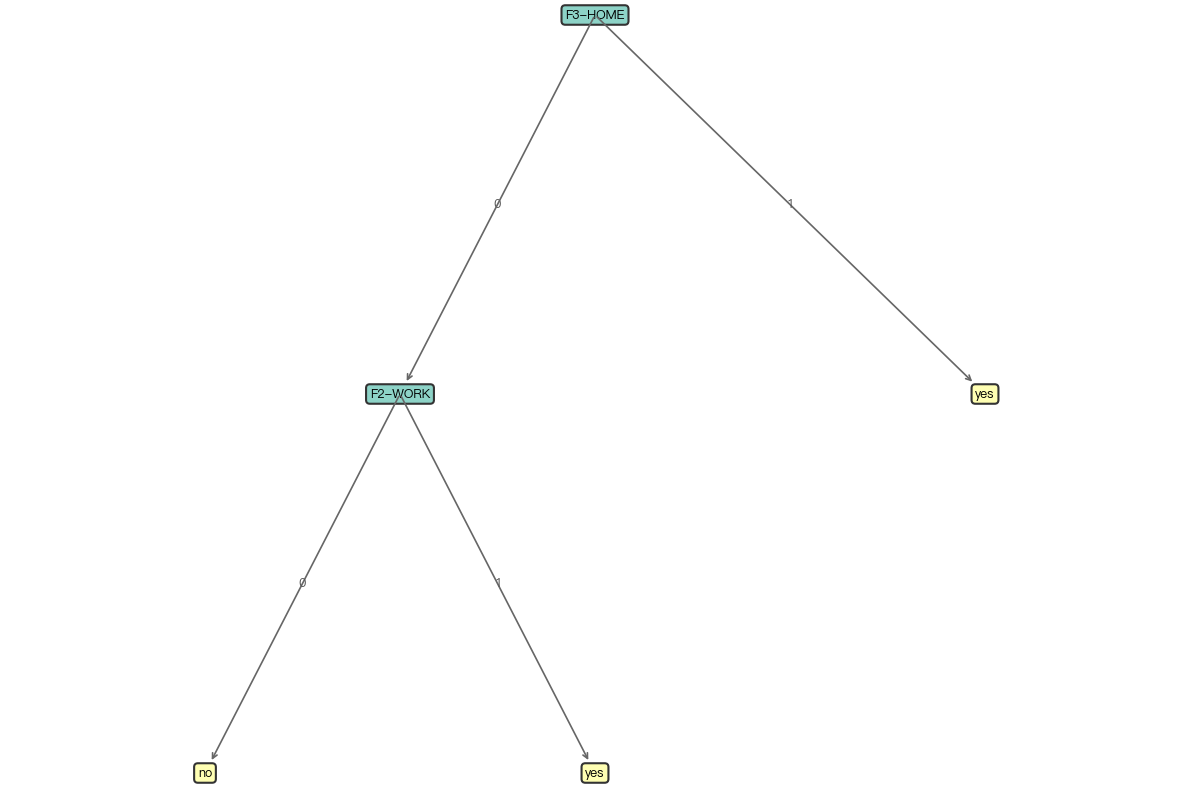

📊 Matplotlib方案统计: 叶子节点=3, 深度=2


In [9]:
dataSet, labels = createDataSet()
tree = creatTree(dataSet, labels[:])





createPlot(tree)


In [ ]:
from pathlib import Path
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import pandas as pd

# ===== Matplotlib决策树可视化 =====

decisionNode = dict(boxstyle="round,pad=0.3", fc="#8dd3c7", ec="#333", lw=1.5)
leafNode = dict(boxstyle="round,pad=0.3", fc="#ffffb3", ec="#333", lw=1.5)
arrow_args = dict(arrowstyle="<-", lw=1.2, color='#666')

def _resolve_font(size: int = 10):
    """解析可用字体"""
    candidates = [
        Path("/System/Library/Fonts/PingFang.ttc"),
        Path("/System/Library/Fonts/Hiragino Sans GB.ttc"),
    ]
    for candidate in candidates:
        if candidate.exists():
            return FontProperties(fname=str(candidate), size=size)
    return FontProperties(size=size)

fontProps = _resolve_font(9)

def getNumLeafs(myTree):
    """计算叶子节点数"""
    numLeafs = 0
    firstStr = next(iter(myTree))
    secondDict = myTree[firstStr]
    for key in secondDict:
        if isinstance(secondDict[key], dict):
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    """计算树深度"""
    maxDepth = 0
    firstStr = next(iter(myTree))
    secondDict = myTree[firstStr]
    for key in secondDict:
        if isinstance(secondDict[key], dict):
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType, ax):
    """绘制节点"""
    ax.annotate(str(nodeTxt)[:20], xy=parentPt, xycoords='axes fraction',
                xytext=centerPt, textcoords='axes fraction',
                va="center", ha="center", bbox=nodeType,
                arrowprops=arrow_args, fontproperties=fontProps)

def plotMidText(cntrPt, parentPt, txtString, ax):
    """绘制边上的文本"""
    xMid = (parentPt[0] + cntrPt[0]) / 2.0
    yMid = (parentPt[1] + cntrPt[1]) / 2.0
    ax.text(xMid, yMid, str(txtString)[:10], va="center", ha="center",
            fontproperties=fontProps, color='#555')

def plotTree(myTree, parentPt, nodeTxt, ax):
    """递归绘制决策树"""
    numLeafs = getNumLeafs(myTree)
    firstStr = next(iter(myTree))
    cntrPt = (plotTree.xOff + (1.0 + numLeafs) / 2.0 / plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt, ax)
    plotNode(firstStr, cntrPt, parentPt, decisionNode, ax)
    secondDict = myTree[firstStr]
    plotTree.yOff -= 1.0 / plotTree.totalD
    for key in secondDict:
        if isinstance(secondDict[key], dict):
            plotTree(secondDict[key], cntrPt, str(key), ax)
        else:
            plotTree.xOff += 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode, ax)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key), ax)
    plotTree.yOff += 1.0 / plotTree.totalD

def createPlot(myTree):
    """Matplotlib可视化"""
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    
    # 动态调整图形大小
    width = max(12, numLeafs * 0.8)
    height = max(8, depth * 1.5)
    width = min(width, 50)  # 限制最大宽度
    height = min(height, 30)  # 限制最大高度
    
    fig, ax = plt.subplots(figsize=(width, height), facecolor='white')
    ax.set_axis_off()
    
    plotTree.totalW = float(numLeafs)
    plotTree.totalD = float(depth)
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    
    plotTree(myTree, (0.5, 1.0), '', ax)
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Matplotlib方案统计: 叶子节点={numLeafs}, 深度={depth}")

### CSV数据清洗

In [11]:
import pandas as pd

def csv_to_dataset(csv_path: str, exclude_cols=None):
    """
    通用CSV转决策树数据集格式
    默认最后一列为标签，其他列为特征
    
    参数:
        csv_path: CSV文件路径
        exclude_cols: 要排除的列名列表（如ID列）
    
    返回:
        dataSet: [[特征1, 特征2, ..., 标签], ...] 格式的列表
        labels: 特征列名列表
    """
    # 读取CSV
    df = pd.read_csv(csv_path)
    
    # 排除指定列
    if exclude_cols:
        df = df.drop(columns=exclude_cols)
    
    # 最后一列为标签，其他为特征
    feature_cols = df.columns[:-1].tolist()
    
    # 直接转为列表格式
    dataSet = df.values.tolist()
    
    return dataSet, feature_cols

### 数据集二

🎯 方案2: Graphviz超高清矢量图研究

【方案2】Graphviz超高清矢量图（SVG+PNG）
--------------------------------------------------------------------------------
✅ DOT文件已生成: /Users/austins/Statistical Learning-reproduction/decision_tree_clean.dot
✅ SVG超高清图已生成: /Users/austins/Statistical Learning-reproduction/decision_tree_clean.svg
✅ PNG图已生成: /Users/austins/Statistical Learning-reproduction/decision_tree_clean.png


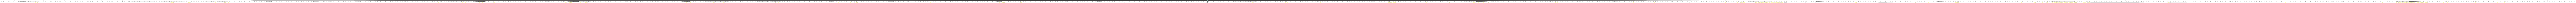


📊 Graphviz方案统计:
   叶子节点数: 4387
   树深度: 3
   节点总数: 4907


In [ ]:
# 加载数据
dataSet_clean, labels_clean = csv_to_dataset(
    '/Users/austins/Statistical Learning-reproduction/data/bankloan.csv',
    exclude_cols=['ID']
)
tree_clean = creatTree(dataSet_clean, labels_clean[:])

print("="*80)
print("🎯 决策树可视化（Matplotlib）")
print("="*80)

createPlot(tree_clean)